In [1]:
from astropy.io import fits
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim

import time
import os

In [27]:
######################## define constants etc. ############################### 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

rootpath = '/n/holyscratch01/dvorkin_lab/Users/tianliwang/maps_unzipped/'  # location of maps 
workPath = '/n/holyscratch01/dvorkin_lab/Users/tianliwang/'
#rootpath = '/Volumes/WTL/convergence_maps/All_cosm/'  # <-- Tianli's testing file path
#workPath = '/Users/Ed/Desktop/cosm_prjt/'  # path to load the net from and write the predictions in

# these parameters are defined in the paper  
n_imagespercosmo = 512  # number of images per cosmology 
n_perbatch = 32         # batch size for training 
n_perbatch_test = n_perbatch  # the value shoudn't matter but put here in case we need to change things
n_batch = n_imagespercosmo/n_perbatch  # number of minibatches 
dim_image = 1024 
dim_downsized = int(dim_image/2)            # downsized image dimension 

trainFraction = 10.0/16  # fraction of images per cosmology for training 
validateFraction = 3.0/16
testFraction = 1-trainFraction-validateFraction  # needs more cleaning up 

n_cosmosToTrain = 90  # same for validation and testing
n_trainimages = int(n_imagespercosmo*trainFraction)    # number of images per cosmology to train
n_validateimages = int(n_imagespercosmo*validateFraction)   # number of images per cosmology to validate
n_testimages = int(n_imagespercosmo*testFraction)  # number of images per cosmology to test
n_batch_train = int(n_trainimages/n_perbatch)  # number of minibatches per cosmology to train 

# start and end image indices for training and validating 
startIndices_train = np.ones(n_cosmosToTrain).astype(int)
endIndices_train = n_trainimages*np.ones(n_cosmosToTrain).astype(int)
startIndices_validate = (n_trainimages+1)*np.ones(n_cosmosToTrain).astype(int)
endIndices_validate = (n_trainimages+n_validateimages)*np.ones(n_cosmosToTrain).astype(int)
startIndices_test = (n_trainimages+n_validateimages+1)*np.ones(n_cosmosToTrain).astype(int)
endIndices_test = (n_trainimages+n_validateimages+n_testimages)*np.ones(n_cosmosToTrain).astype(int)

# print(startIndices_test, endIndices_test)  # shoud be 481 and 512 (just testing)


######################## define functions & Class ###############################

def read_parametersfromfile(path):
    '''
    Input: string for the directory to the folders of cosmology 
    
    Function: reads the Omega_m and sigma_8 values from the folder names in 
    the path directory and store them as arrays of strings. Stores the values 
    as strings to avoid rounding, for example, 0.600 to 0.6. 
    
    Output: (array of strings of Omega_m, array of strings of sigma_8)
    '''
    
    Om_strings = [] 
    si_strings = []
    
    for filename in os.listdir(path):
        if (filename.startswith('Om') and not filename.endswith('.gz')): 
            Om_strings.append(filename[2:7]) 
            si_strings.append(filename[10:15])
            
    return Om_strings, si_strings


def read_files(path, Oms, sis, start_indices, end_indices): 
    '''
    Input: file root directory path, strings of omegam and sigma8 values, 
    start image indices and end image indices. Oms, sis, start_indices, end_indices
    should be arrays of same length. 
    
    Function: reads the images labeled between start_indices[i] and end_indices[i] (inclusive)
    for each of the ith cosmologies specified by omegam and sigma8 values 
    
    Output: numpy array of 3D images
    '''
    
    n_cosmos = len(Oms)  # this should be shared by Oms, sis, start_indices, end_indices 
    
    # read in the files and put them into 3D matrix 
    filedata = []

    for j in range(0, n_cosmos): 
        i_start = start_indices[j]
        i_end = end_indices[j]
        Om = Oms[j]
        si = sis[j]
        
        for i in range(i_start, i_end+1): 
            if (i < 10): filenum = '00{}'.format(i)
            elif (i < 100): filenum = '0{}'.format(i)
            else: filenum = i 

            hdulist = fits.open('{}Om{}_si{}/WLconv_z1.00_0{}r.fits'.format(path, Om, si, filenum))
            image = hdulist[0].data

            # downsize from dim_image to dim_downsized 
            image_downsized = image.reshape([dim_downsized, dim_image//dim_downsized, 
                                    dim_downsized, dim_image//dim_downsized]).mean(3).mean(1)

            # newaxis makes the image 3D (1x512x512) 
            filedata.append(image_downsized[np.newaxis,:,:])
    
    return np.array(filedata)
           
    
def test_cnn(network, testinputs, batchsize, isTrackingloss, **kwargs): 
    '''
    Input: CNN object, testing data, batch size for testing, boolean for whether 
    to track losses bewteen test ouputs and targets, **kwargs includes the loss function
    criterion and the targetting outputs. Target should be in the form of 
    an array of (omegam, sigma8) parameters each corresponding to the target of one batch. 
    
    Call with 
    test_cnn(network, testinputs, batchsize, False) 
    or 
    test_cnn(network, testinputs, batchsize, True, loss_fn=loss_fn, target=target)
    
    Function: Run the network with test inputs and specified batch size and track loss as 
    requested in torch.no_grad() environment. 
    
    Output: 
    If isTrackingloss is True, return (np array of predicted outputs, np array of losses for each batch)
    If isTrackingloss is False, return np array of predicted outputs
    '''
    
    # unpack optional arguments **kwargs 
    if (isTrackingloss): 
        loss_fn = kwargs.get('loss_fn', None)
        testtargets = kwargs.get('target', None)
        losses = []
    
    # make the data into 4D tensor and put each batch into iterable 
    testloader = torch.utils.data.DataLoader(testinputs, batch_size=batchsize, shuffle=False)
    
    predictions = []  # stores outputs of network with test data inputs 
    
    with torch.no_grad(): 
        for i, testdata in enumerate(testloader, 0):
            testdata = testdata.to(device)  # GPU
            testoutputs = network(testdata)
            
            predictions = predictions + testoutputs.cpu().tolist()

            if (isTrackingloss): 
                testtarget = torch.tensor(testtargets[i]).repeat(batchsize, 1)  
##                print(testtarget)
                testtarget = testtarget.to(device)  # GPU
                loss = np.array([(loss_fn(testoutputs[i], testtarget[i])).cpu() for i in range(batchsize)])
                losses.append(loss)
##                print(loss)
    
    if (isTrackingloss): 
        return np.array(predictions), np.array(losses)
    
    return np.array(predictions)

cuda:0


In [3]:
# network structure 

def conv_block(in_f, out_f, *args, **kwargs):
    return nn.Sequential(
        nn.Conv2d(in_f, out_f, *args, **kwargs),
        nn.BatchNorm2d(out_f),
        nn.ReLU()
    )

class Net (nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.cnn_layers = nn.Sequential(
            # layers 1+2 
            conv_block(1, 32, kernel_size=3), 
            conv_block(32, 32, kernel_size=3), 
            nn.AvgPool2d(2, 2), 
            # layers 3+4
            conv_block(32, 64, kernel_size=3), 
            conv_block(64, 64, kernel_size=3), 
            nn.AvgPool2d(2, 2), 
            # layers 5-7 
            conv_block(64, 128, kernel_size=3),
            conv_block(128, 64, kernel_size=1),
            conv_block(64, 128, kernel_size=3),
            nn.AvgPool2d(2, 2),
            # layers 8-10 
            conv_block(128, 256, kernel_size=3),
            conv_block(256, 128, kernel_size=1),
            conv_block(128, 256, kernel_size=3),
            nn.AvgPool2d(2, 2),
            # layers 11-13 
            conv_block(256, 512, kernel_size=3),
            conv_block(512, 256, kernel_size=1),
            conv_block(256, 512, kernel_size=3),
            nn.AvgPool2d(2, 2),
            # layers 14-18 
            conv_block(512, 512, kernel_size=3),
            conv_block(512, 256, kernel_size=1),
            conv_block(256, 512, kernel_size=3),
            conv_block(512, 256, kernel_size=1),
            nn.Conv2d(256, 512, kernel_size=3),
            nn.ReLU(),             # no batch norm on last convolution layer 
            nn.AvgPool2d(6, 6)
        )
        
        self.fc = nn.Linear(512, 2)

    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(-1, 512)
        x = self.fc(x)
        
        return x

In [28]:
# read in all the omegam and sigma8 values from the directory 
Omegam_strings, sigma8_strings = read_parametersfromfile(rootpath)

Omegastrings_test = Omegam_strings[:n_cosmosToTrain]
sigmastrings_test = sigma8_strings[:n_cosmosToTrain]
Omegas_test = np.array(Omegastrings_test).astype(np.float)
sigmas_test = np.array(sigmastrings_test).astype(np.float)

start_time = time.time()  
inputs_test = read_files(rootpath, Omegastrings_test, sigmastrings_test, 
                             startIndices_test, endIndices_test)
print("--- Time to load the test files: %s seconds ---" % (time.time() - start_time), flush=True)

--- Time to load the test files: 520.917245388031 seconds ---


In [29]:
net = Net()
net.to(device)  #GPU
path_net = workPath+'fullNet_gpu_90Cosmo_30epoch.pth'
#net.load_state_dict(torch.load(path_net, map_location=torch.device('cpu')))  # delet the cpu option
net.load_state_dict(torch.load(path_net))

<All keys matched successfully>

In [30]:
# Testing

criterion = nn.L1Loss()  # MAE loss 

start_time = time.time() 

n_batch_test = int(n_testimages/n_perbatch_test)
targets_temp = np.concatenate((np.array([Omegas_test]).T, np.array([sigmas_test]).T), axis=1) # temp stacked targets of all comsos being trained
targets_test = np.repeat(targets_temp, n_batch_test, axis=0)  # repeat each set of parameters by the number of batches
#outputs_test = test_cnn(net, inputs_test, n_perbatch_test, False)  # not tracking loss
outputs_test, losses_test = test_cnn(net, inputs_test, n_perbatch_test, True, loss_fn=criterion, target=targets_test)    

print("--- Testing time: %s seconds ---" % (time.time() - start_time), flush=True)

--- Testing time: 36.80047869682312 seconds ---


In [31]:
Om_predict = outputs_test[:,0]
si_predict = outputs_test[:,1]
expected_outputs = np.repeat(targets_test, n_perbatch_test, axis=0)

Om_predictavg = np.reshape(Om_predict, (-1, n_testimages)).mean(axis=-1)
si_predictavg = np.reshape(si_predict, (-1, n_testimages)).mean(axis=-1)

In [36]:
t = Table([Om_predict, si_predict, expected_outputs[:,0], expected_outputs[:,1], np.ndarray.flatten(losses_test)], 
          names=('Om_pred', 'si_pred', 'Om_expect', 'si_expect', 'Losses'))
#t.write(workPath+'fullNet_testing.dat', format='ascii', overwrite=True)

In [64]:
#print(Om_predict)
#print(si_predict)
#print(expected_outputs[:,0])
#print(expected_outputs[:,1])

Text(0, 0.5, '$\\Omega_{\\rm{m}}$ predicted')

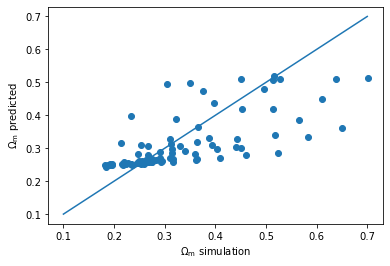

In [68]:
x = np.arange(0.1, 0.8, 0.1)
plt.plot(x, x)
plt.scatter(Omegas_test, Om_predictavg)
plt.xlabel(r'$\Omega_{\rm{m}}$ simulation')
plt.ylabel(r'$\Omega_{\rm{m}}$ predicted')

Text(0, 0.5, '$sigma_8$ predicted')

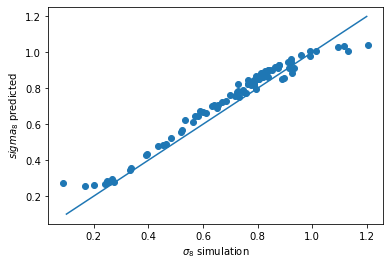

In [69]:
x = np.arange(0.1, 1.3, 0.1)
plt.plot(x, x)
plt.scatter(sigmas_test, si_predictavg)
plt.xlabel(r'$\sigma_8$ simulation')
plt.ylabel(r'$sigma_8$ predicted')